<a href="https://colab.research.google.com/github/thaivu4122/snake-stm32/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_BTL_De_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Đã tạo 100 nút. Nút trung tâm: 15

--- BẮT ĐẦU CÂU 1 ---
Tổng chi phí mạng (Câu 1): 1718


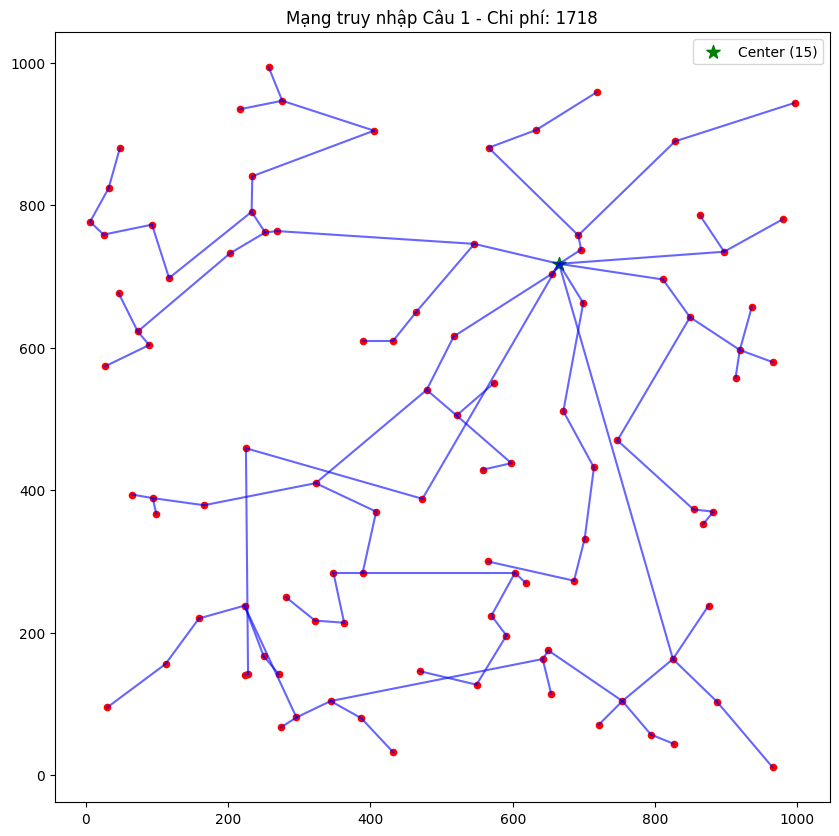


--- BẮT ĐẦU CÂU 2 ---
Tổng chi phí mạng (Câu 2 - Có thêm Link Type 4): 1580
Sự thay đổi: Giảm 138

--- BẮT ĐẦU CÂU 3 ---
Tổng chi phí mạng (Câu 3 - Giới hạn 5 nút/cây): 2121


In [ ]:
import math
import random
import matplotlib.pyplot as plt

# --- CẤU HÌNH ---
NUM_NODES = 100
MAP_SIZE = 1000
CENTER_ID = 15
OUTPUT_FILE = "ket_qua_mang.txt"

# Cấu hình trọng số (Lưu lượng)
def get_node_weight(node_id):
    # Lưu ý: node_id trong đề bài chạy từ 1 đến 100
    if node_id in [1, 28, 44]: return 2
    if node_id in [19, 48, 64]: return 7
    if node_id in [17, 25, 59]: return 18
    if node_id in [4, 43, 55]: return 8
    if node_id in [7, 56, 75]: return 3
    if node_id in [72, 46, 95]: return 20
    if node_id == CENTER_ID: return 0 # Nút trung tâm không có nhu cầu tải
    return 1 # Các nút khác

# --- LỚP ĐỐI TƯỢNG NÚT ---
class Node:
    def __init__(self, id, x, y, weight):
        self.id = id
        self.x = x
        self.y = y
        self.weight = weight # Nhu cầu lưu lượng riêng
        self.subtree_load = weight # Tổng lưu lượng nhánh con (ban đầu bằng chính nó)
        self.parent = None # Nút cha
        self.children = [] # Danh sách con

def dist(n1, n2):
    return math.sqrt((n1.x - n2.x)**2 + (n1.y - n2.y)**2)

# --- HÀM TÍNH GIÁ LIÊN KẾT (CÂU 1 & 2) ---
def get_link_cost(distance, load, use_link_4=False):
    # Câu 1: 3 loại liên kết
    # Câu 2: Thêm loại 4

    cost = float('inf')

    if load <= 6:
        cost = round(0.1 * distance)
    elif load <= 15:
        cost = round(0.2 * distance)
    elif load <= 45:
        cost = round(0.4 * distance)
    elif use_link_4 and load <= 80:
        cost = round(0.6 * distance)

    return cost

# --- THUẬT TOÁN ESAU-WILLIAMS (MSLA HEURISTIC) ---
def solve_msla(nodes_dict, use_link_4=False, max_nodes_limit=None):
    # 1. Khởi tạo: Mọi nút đều nối trực tiếp về Center (Star Topology)
    center = nodes_dict[CENTER_ID]
    clusters = {} # Mỗi cluster đại diện bởi gốc của nhánh đó (kết nối trực tiếp với Center)

    # Reset trạng thái
    for nid, node in nodes_dict.items():
        if nid != CENTER_ID:
            node.parent = center
            node.children = []
            node.subtree_load = node.weight
            clusters[nid] = [node] # Mỗi nút ban đầu là 1 cluster

    center.children = [n for nid, n in nodes_dict.items() if nid != CENTER_ID]

    # 2. Tính toán Trade-off (Savings) để gộp các nhánh
    # Tradeoff = Cost(i -> Center) - Cost(i -> j) (với điều kiện j gần Center hơn hoặc gộp được)
    # Tuy nhiên Esau-Williams chuẩn:
    # Tradeoff(i, j) = Cost(Link i->Center) - Cost(Link i->j) + Penalty (nếu có)
    # Chúng ta muốn TỐI ĐA HÓA cái này (Tiết kiệm được nhiều nhất)

    while True:
        best_tradeoff = -float('inf')
        best_merge = None # (node_i, node_j) -> i sẽ nối vào j thay vì nối vào Center

        cluster_roots = list(clusters.keys())

        for i_id in cluster_roots:
            root_i = nodes_dict[i_id]
            dist_i_center = dist(root_i, center)
            cost_i_center = get_link_cost(dist_i_center, root_i.subtree_load, use_link_4)

            # Nếu bản thân nhánh này đã quá tải không thể nối center (trường hợp hiếm), bỏ qua
            if cost_i_center == float('inf'): continue

            for j_id in nodes_dict: # j có thể là bất kỳ nút nào khác (không nhất thiết là root)
                if i_id == j_id or j_id == CENTER_ID: continue

                # Kiểm tra xem j thuộc cluster nào
                j_root_id = None
                for rid, members in clusters.items():
                    if nodes_dict[j_id] in members:
                        j_root_id = rid
                        break

                if i_id == j_root_id: continue # Cùng một cụm thì không gộp

                node_j = nodes_dict[j_id]
                root_j = nodes_dict[j_root_id]

                # Kiểm tra ràng buộc tải gộp
                new_load = root_i.subtree_load + root_j.subtree_load

                # Kiểm tra ràng buộc số lượng nút (Câu 3)
                if max_nodes_limit:
                    total_nodes = len(clusters[i_id]) + len(clusters[j_root_id])
                    if total_nodes > max_nodes_limit:
                        continue

                # Tính khoảng cách i -> j
                d_ij = dist(root_i, node_j)

                # Chi phí nếu gộp:
                # Nhánh i sẽ đi qua j. Vậy i->j phải chịu tải của cả nhánh i.
                # Sau đó nhánh j (gồm cả i) đi về Center.

                # Esau-Williams đơn giản: So sánh việc cắt i->Center và thêm i->j
                # Điều kiện: Gộp xong thì nhánh mới (gốc là root_j) phải đi về Center được
                dist_j_center = dist(root_j, center)
                cost_merged_center = get_link_cost(dist_j_center, new_load, use_link_4)

                cost_link_ij = get_link_cost(d_ij, root_i.subtree_load, use_link_4)

                # Nếu gộp lại mà quá tải đường về Center hoặc đường liên kết i-j quá tải
                if cost_merged_center == float('inf') or cost_link_ij == float('inf'):
                    continue

                # Tính độ lợi (Savings)
                # Trước khi gộp: Cost(i->Center) + Cost(j->Center)
                # Sau khi gộp: Cost(i->j) + Cost(merged_j->Center)
                # Tuy nhiên EW thường dùng heuristic cục bộ: Tradeoff = Cost(i->Center) - Cost(i->j)
                # Nhưng với bài toán đa cấp giá (Multi-level cost), ta nên so sánh tổng phí

                current_cost = get_link_cost(dist_i_center, root_i.subtree_load, use_link_4) + \
                               get_link_cost(dist_j_center, root_j.subtree_load, use_link_4)

                new_total_cost = cost_link_ij + cost_merged_center

                saving = current_cost - new_total_cost

                if saving > 0 and saving > best_tradeoff:
                    best_tradeoff = saving
                    best_merge = (i_id, j_id, j_root_id)

        if best_merge:
            i_id, j_id, j_root_id = best_merge
            # Thực hiện gộp
            # i không còn nối Center nữa, i nối vào j
            node_i = nodes_dict[i_id]
            node_j = nodes_dict[j_id]

            node_i.parent = node_j
            node_j.children.append(node_i)

            # Cập nhật tải cho toàn bộ đường đi từ j về root của cụm j
            # (Ở bước này ta chỉ quan tâm root_j mang tải tổng)
            root_j = nodes_dict[j_root_id]
            root_j.subtree_load += node_i.subtree_load

            # Gộp danh sách nodes
            clusters[j_root_id].extend(clusters[i_id])
            del clusters[i_id]

            # Xóa i khỏi danh sách con của Center
            if node_i in center.children:
                center.children.remove(node_i)

        else:
            break # Không còn nước đi nào giảm chi phí

    return clusters

# --- HÀM TÍNH TỔNG CHI PHÍ ---
def calculate_total_network_cost(nodes_dict, use_link_4=False):
    total_cost = 0
    for nid, node in nodes_dict.items():
        if nid == CENTER_ID: continue

        # Tìm cha
        parent = node.parent
        if parent:
            d = dist(node, parent)
            # Tải đi qua liên kết này chính là tải của nhánh (subtree) tại node này
            load = node.subtree_load
            c = get_link_cost(d, load, use_link_4)
            total_cost += c
    return total_cost

# --- MAIN ---
def main():
    # 1. Khởi tạo dữ liệu
    random.seed(42) # Cố định seed để kết quả giống nhau mỗi lần chạy
    nodes = {}

    # Tạo tọa độ ngẫu nhiên
    for i in range(1, NUM_NODES + 1):
        x = random.randint(0, MAP_SIZE)
        y = random.randint(0, MAP_SIZE)
        w = get_node_weight(i)
        nodes[i] = Node(i, x, y, w)

    print(f"Đã tạo {NUM_NODES} nút. Nút trung tâm: {CENTER_ID}")

    # --- CÂU 1 ---
    print("\n--- BẮT ĐẦU CÂU 1 ---")
    # Reset cấu trúc cây
    clusters_q1 = solve_msla(nodes, use_link_4=False, max_nodes_limit=None)
    cost_q1 = calculate_total_network_cost(nodes, use_link_4=False)

    print(f"Tổng chi phí mạng (Câu 1): {cost_q1}")

    # Ghi file
    with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
        f.write("KET QUA CAU 1:\n")
        f.write(f"Tong chi phi: {cost_q1}\n")
        f.write("Danh sach lien ket:\n")
        f.write("Node_ID -> Parent_ID | Distance | Subtree_Load | Cost\n")
        for nid, node in nodes.items():
            if nid != CENTER_ID and node.parent:
                d = dist(node, node.parent)
                c = get_link_cost(d, node.subtree_load, False)
                f.write(f"{nid:3d} -> {node.parent.id:3d} | {d:6.2f} | {node.subtree_load:3d} | {c}\n")

    # Vẽ hình Câu 1
    plt.figure(figsize=(10, 10))
    for nid, node in nodes.items():
        if nid != CENTER_ID and node.parent:
            plt.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.6)

    # Vẽ các nút
    xs = [n.x for n in nodes.values()]
    ys = [n.y for n in nodes.values()]
    plt.scatter(xs, ys, c='red', s=20)
    # Vẽ nút trung tâm
    center = nodes[CENTER_ID]
    plt.scatter([center.x], [center.y], c='green', s=100, marker='*', label='Center (15)')
    plt.title(f"Mạng truy nhập Câu 1 - Chi phí: {cost_q1}")
    plt.legend()
    plt.show()

    # --- CÂU 2 ---
    print("\n--- BẮT ĐẦU CÂU 2 ---")
    # Cần reset lại trạng thái nút trước khi chạy lại
    # (Tạo lại object node để xóa các liên kết cũ)
    nodes_q2 = {}
    for i in range(1, NUM_NODES + 1):
        # Dùng lại tọa độ cũ từ nodes ban đầu để so sánh công bằng
        nodes_q2[i] = Node(i, nodes[i].x, nodes[i].y, get_node_weight(i))

    solve_msla(nodes_q2, use_link_4=True, max_nodes_limit=None)
    cost_q2 = calculate_total_network_cost(nodes_q2, use_link_4=True)

    print(f"Tổng chi phí mạng (Câu 2 - Có thêm Link Type 4): {cost_q2}")
    diff = cost_q2 - cost_q1
    print(f"Sự thay đổi: {'Tăng' if diff > 0 else 'Giảm'} {abs(diff)}")

    # --- CÂU 3 ---
    print("\n--- BẮT ĐẦU CÂU 3 ---")
    nodes_q3 = {}
    for i in range(1, NUM_NODES + 1):
        nodes_q3[i] = Node(i, nodes[i].x, nodes[i].y, get_node_weight(i))

    solve_msla(nodes_q3, use_link_4=True, max_nodes_limit=5)
    cost_q3 = calculate_total_network_cost(nodes_q3, use_link_4=True)
    print(f"Tổng chi phí mạng (Câu 3 - Giới hạn 5 nút/cây): {cost_q3}")

if __name__ == "__main__":
    main()